In [1]:
#load modules
print('loading modules...')
import numpy as np
#import cmb
import healpy as hp
import pymaster as nmt
import matplotlib.pyplot as plt

##########################################################################

import os,sys
import pylab as pl
import numpy as np
import lenspyx
import healpy as hp

import pysm3
import pysm3.units as u


camb_path = os.path.realpath(os.path.join(os.getcwd(),'..'))    
sys.path.insert(0,camb_path)

import camb
from camb import model, initialpower ,correlations

from scipy.special import factorial

sys.path.append('./components')

loading modules...


In [2]:
nside = 1024
lmax = 3*nside-1

# These are the necessary dependence to run this simulation：

numpy 

camb

healpy

scipy

matplotlib

pysm3： https://pysm3.readthedocs.io/en/latest/index.html#installation

lenspyx：https://github.com/carronj/lenspyx

# One-step simulator

In [ ]:
from simulator import *

from config import DEFAULT_CONFIG
sim = SkySimulator(DEFAULT_CONFIG)
obs_all, phi = sim.simulate()

loading modules...
loading modules...
loading modules...
-----------------------------------------------------------------
****************  Simulating CMB ****************
Setting parameters...
Lensing...
alm2lenmap: using 14 nthreads
  build angles <- synthesis (GRAD_ONLY):  [0:00:00.733431] (12.1%)  
  build angles <- th-phi-gm (ducc)     :  [0:00:00.048355] (0.8%)  
  build_angles                         :  [0:00:00.781810] (12.9%)  
  synthesis general (STANDARD)         :  [0:00:05.133738] (84.8%)  
  gclm2lenmap                          :  [0:00:05.938900] (98.1%)  
  polrot (ducc)                        :  [0:00:00.023314] (0.4%)  
  Total                                :  [0:00:06.054478] d:h:m:s:mus
Lensed CMB Map generating done !!!
-----------------------------------------------------------------
****************  Simulating Foreground ****************
Generating Gaussian Foreground at 27 GHz
Generating Gaussian Foreground at 39 GHz
Generating Gaussian Foreground at 93 GHz


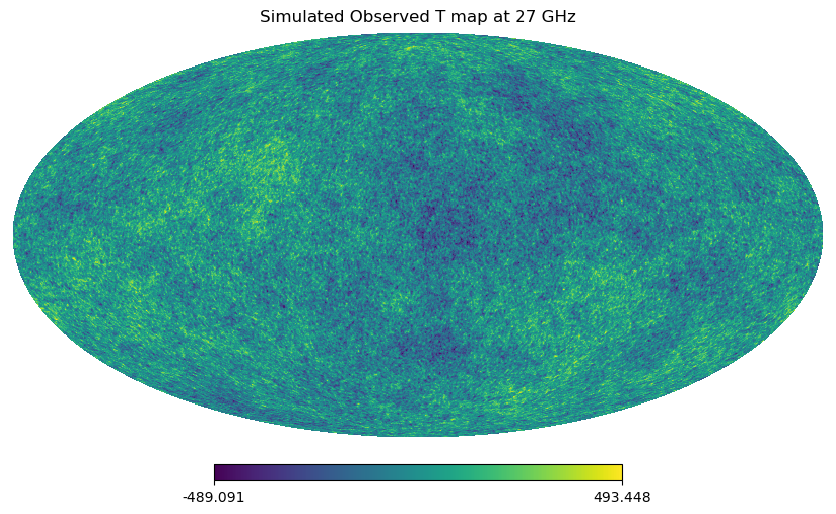

In [ ]:
hp.mollview(obs_all[0][0], title='Simulated Observed T map at 27 GHz',)

# Below generate each components by hands

# CMB

In [3]:
from cmb_making import *

T1,Q1,U1,P1 = making_maps_new(nside, fid_source='FFP10', fid_type='cl', lmax=None, dlmax=None, seed=0, epsilon=None, if_lensing=True, )

loading modules...
loading modules...
Setting parameters...
Lensing...
alm2lenmap: using 14 nthreads
  build angles <- synthesis (GRAD_ONLY):  [0:00:00.746039] (12.2%)  
  build angles <- th-phi-gm (ducc)     :  [0:00:00.053164] (0.9%)  
  build_angles                         :  [0:00:00.799224] (13.1%)  
  synthesis general (STANDARD)         :  [0:00:05.102994] (83.4%)  
  gclm2lenmap                          :  [0:00:05.926421] (96.9%)  
  polrot (ducc)                        :  [0:00:00.024148] (0.4%)  
  Total                                :  [0:00:06.118640] d:h:m:s:mus
Lensed CMB Map generating done !!!


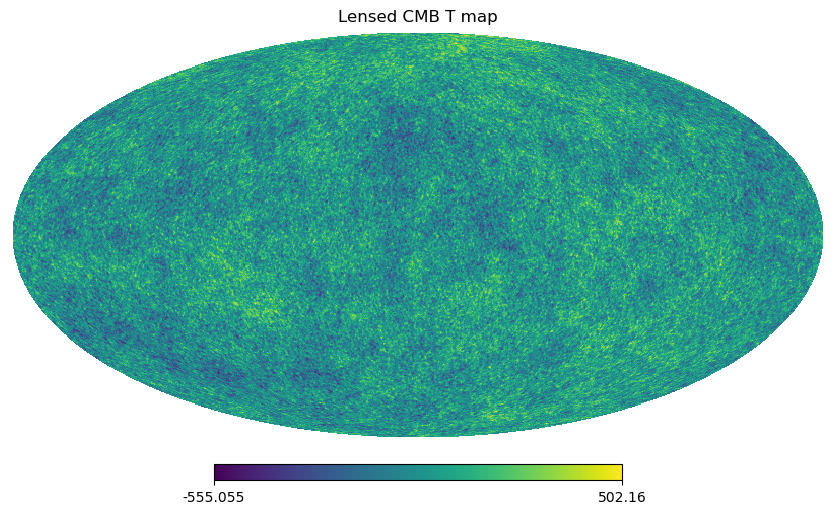

In [4]:
hp.mollview(T1, title='Lensed CMB T map', )

# Noise

In [8]:
from noise_making import *

nlev = [52, 27, 5.8, 6.3, 15, 37]  #uK-arcmin， 对应6个频段
noise_map = homo_noise(nlev[0], nside,  seed=0, )

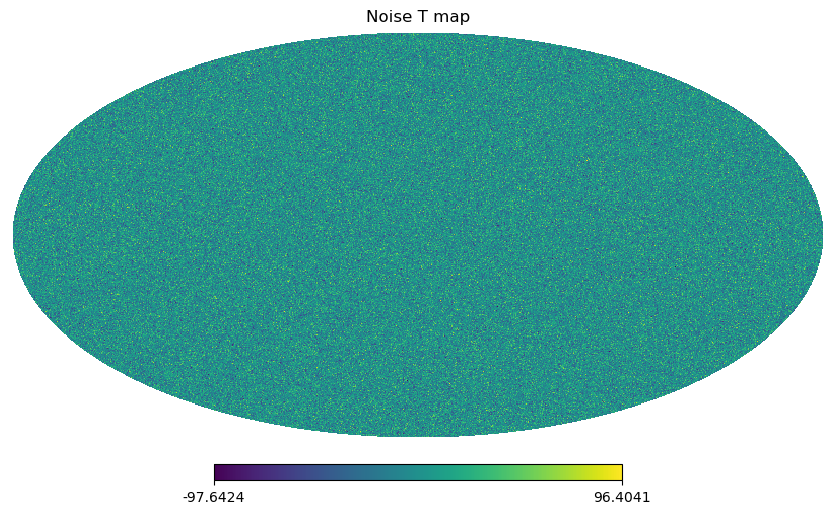

In [9]:
hp.mollview(noise_map[2], title='Noise T map', )

# Foreground (PySM3)

In [ ]:
comps = ["d9", "s4", "a1", "f1", "cib1", "tsz1", "ksz1", "rg1"]   # Notice：decide the fg component by yourself, reference：https://pysm3.readthedocs.io/en/latest/models.html

freq = [27, 39, 93, 145, 225, 280]    # in GHz 

In [ ]:
sky = pysm3.Sky(nside=nside, preset_strings=comps) 

map = sky.get_emission(freq[0] * u.GHz)    # This is in uK_RJ, G cordinate

fg_map_G = map.to(u.uK_CMB, equivalencies=u.cmb_equivalencies(freq * u.GHz))    # This is in uK_CMB, G cordinate

fg_map_C = pysm3.apply_smoothing_and_coord_transform(fg_map_G, rot=hp.Rotator(coord="GC"))  # Convert from Galactic to Celestial coordinates

# Foreground (Gaussian realization)

In [4]:
from foreground_making import *


In [5]:
nu = 145

nus = {nu: nu*1e9}

# TQU map

fg_map,Dl_total_BB = gaussian_fg(nside, nus, 0, same=False, method=1, A_d_b = 14.30, alpha_d_b = -0.65, A_s_b = 2.40, alpha_s_b = -0.80, beta_d = 1.48, beta_s = -3.10, eps_ds = 0,
                            A_d_e = 24.00, alpha_d_e = -0.60, A_s_e = 5.10, alpha_s_e = -0.88, A_d_t = 220.00, alpha_d_t = -0.60, A_s_t = 5.10, alpha_s_t = -0.83,)

In [26]:
cl_fg = hp.anafast(fg_map[nu])

Text(0.5, 1.0, 'Foreground Power Spectra at 145 GHz')

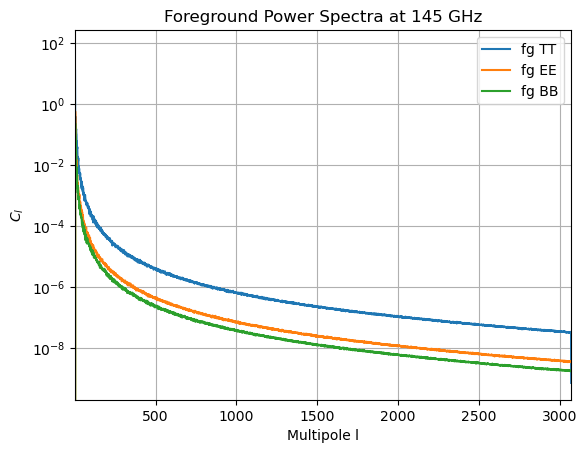

In [31]:
plt.semilogy(cl_fg[0], label='fg TT')
plt.semilogy(cl_fg[1], label='fg EE')
plt.semilogy(cl_fg[2], label='fg BB')

plt.legend()
plt.grid()
plt.xlim(2, lmax)
plt.xlabel('Multipole l')
plt.ylabel('$C_l$')
plt.title(f'Foreground Power Spectra at {nu} GHz')


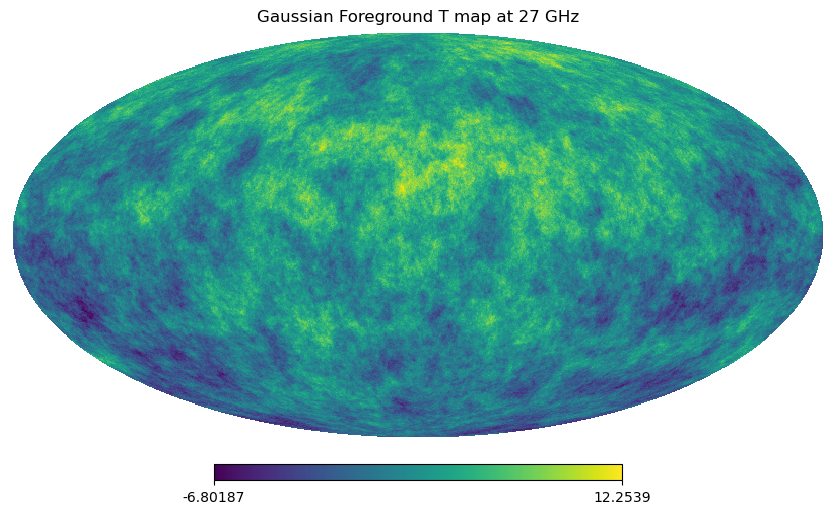

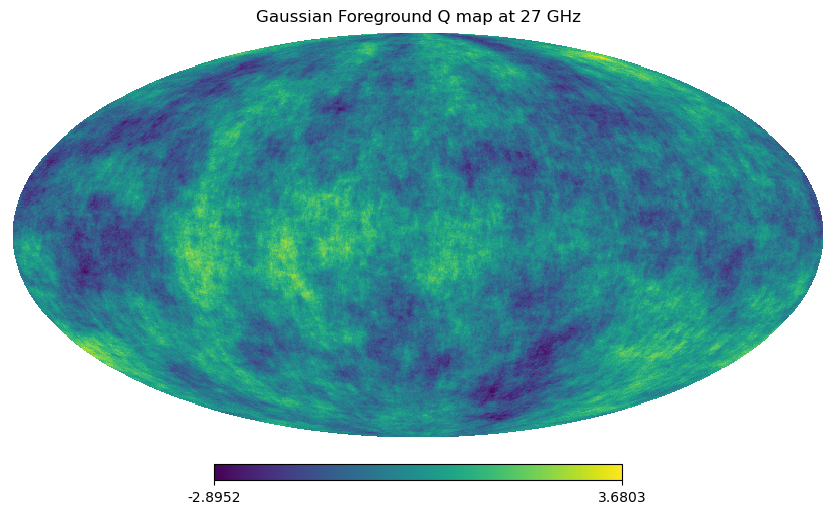

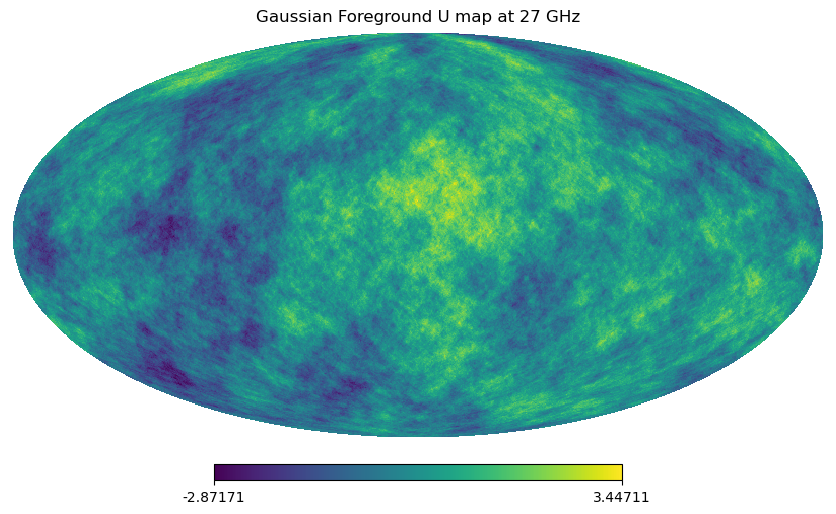

In [29]:
hp.mollview(fg_map[nu][0], title='Gaussian Foreground T map at 27 GHz', )
hp.mollview(fg_map[nu][1], title='Gaussian Foreground Q map at 27 GHz', )
hp.mollview(fg_map[nu][2], title='Gaussian Foreground U map at 27 GHz', )

# Combine all the components

In [ ]:
beam = [7.4, 5.1, 2.2, 1.4, 1.0, 0.9]

### Here is an example for 27 GHz

In [ ]:
CMB_maps = [T1, Q1, U1]

noise_maps_27 = noise(nlev[0], nside,  seed=0,)

from foreground_making import *
fg_maps_27 = pysm_generator(nside, comps, freq[0], unit="uK_CMB", cordinate='G')

In [ ]:
total_obs_maps_27 = hp.smoothing(CMB_maps  + fg_maps_27, fwhm=np.deg2rad(beam[0]/60)) + noise_maps_27

In [ ]:
hp.mollview(total_obs_maps_27[0], title='Observed T map', )